# RNN Model For Classifying Tweets

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy.data import Field, TabularDataset, BucketIterator


import train_test_datasets as pdata
from lstm import LSTM
from evaluate import train_model, evaluate, load_checkpoint


In [5]:
# parameters
DATA_PATH = './data/tweets_all.csv'
SAVE_PATH = './data'

TEST_VALID_PERC=0.2
BATCH_SIZE = 32
MAX_SEQ_LEN = 150
BPTT_LENGTH = 64

EPOCHS = 5
LOSS_FN = nn.CrossEntropyLoss
OPTIM_FN = optim.Adam
HIDDEN_DIM = 150
LEARN_RATE = 0.001
DROP_OUT = 0.5
LAYERS = 2

In [6]:
# test and set kernel device
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

Using cpu.


In [7]:
class_weights = pdata.make_data(DATA_PATH, SAVE_PATH, TEST_VALID_PERC)

# adding weights to loss function
class_weights.to(DEVICE)
LOSS_FN = LOSS_FN(weight=class_weights)

Datasets saved.
./data/train.csv saved; 12914 records
./data/valid.csv saved; 1436 records
./data/test.csv saved; 1596 records

checking class balance:
low in train:  4699
high in train:  8215


In [8]:
# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=SAVE_PATH, 
                                           train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)
print("vocab length: ", len(text_field.vocab))

/Users/LokiJo/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


vocab length:  8551


In [9]:
model = LSTM(vocab_len=len(text_field.vocab),
             dropout=DROP_OUT,
             dimension=HIDDEN_DIM,
             layers=LAYERS).to(DEVICE)

optimizer = OPTIM_FN(model.parameters(), lr=LEARN_RATE)

train_model(model=model,
            optimizer=optimizer,
            train_loader=train_iter,
            valid_loader=valid_iter,
            criterion = LOSS_FN,
            num_epochs = EPOCHS,
            file_path = SAVE_PATH,
            device=DEVICE)

Epoch [1/5], Step [202/2020], Train Loss: 0.6978, Valid Loss: 0.6233
Model saved to ==> ./data/model.pt
Model saved to ==> ./data/metrics.pt
Epoch [1/5], Step [404/2020], Train Loss: 0.5753, Valid Loss: 0.5845
Model saved to ==> ./data/model.pt
Model saved to ==> ./data/metrics.pt
Epoch [2/5], Step [606/2020], Train Loss: 0.6685, Valid Loss: 0.5879
Epoch [2/5], Step [808/2020], Train Loss: 0.5217, Valid Loss: 0.5768
Model saved to ==> ./data/model.pt
Model saved to ==> ./data/metrics.pt
Epoch [3/5], Step [1010/2020], Train Loss: 0.6014, Valid Loss: 0.6045
Epoch [3/5], Step [1212/2020], Train Loss: 0.4756, Valid Loss: 0.5807
Epoch [4/5], Step [1414/2020], Train Loss: 0.5175, Valid Loss: 0.6210
Epoch [4/5], Step [1616/2020], Train Loss: 0.4489, Valid Loss: 0.5899
Epoch [5/5], Step [1818/2020], Train Loss: 0.4771, Valid Loss: 0.6353
Epoch [5/5], Step [2020/2020], Train Loss: 0.4347, Valid Loss: 0.6063
Model saved to ==> ./data/metrics.pt
Finished Training!


Model loaded from <== ./data/model.pt
Test Accuracy:  0.6547619047619048
Classification Report:
              precision    recall  f1-score   support

           1     0.6634    0.9281    0.7737      1015
           0     0.5852    0.1773    0.2721       581

    accuracy                         0.6548      1596
   macro avg     0.6243    0.5527    0.5229      1596
weighted avg     0.6349    0.6548    0.5911      1596



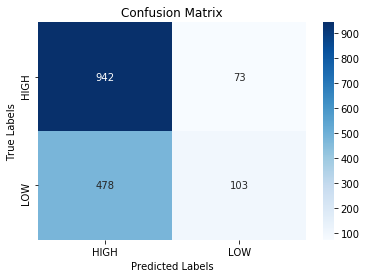

In [10]:
# Evaluate
best_model = LSTM(vocab_len=len(text_field.vocab),
                  dropout=DROP_OUT,
                  dimension=HIDDEN_DIM,
                  layers=LAYERS).to(DEVICE)

optimizer = OPTIM_FN(best_model.parameters(), lr=0.001)

load_checkpoint(SAVE_PATH + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)